# Is NYC surveillance cameras protecting or oppressing BIPOC communities?

### Datasets

<b>Surveillance Cameras<b/> <br/>
    
[ Decode Surveillance Counts Per Intersection Dataset](https://github.com/amnesty-crisis-evidence-lab/decode-surveillance-nyc/blob/main/data/counts_per_intersections.csv)
    
- Counts per intersection dataset is the median of the decoders' counts for each type of camera for each intersection.
- Contains aggregated counts over all intersections characterised by a unqiue PanromaID
- Each intersection is over different areas of NY and its related information (Panorama Id) or whether there is a Traffic Signal present.
The Panorama Id is derived from actual latitudes and longitudes of panoramas returned by Street Veiw from Google Maps.    
    
<b>NYC Borough Boundaries <b/> <br/>

[Source](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)

<b>Population Density <b/> <br/>
    
[LandScan Daytime/Nighttime Dataset](https://landscan.ornl.gov/)
- LandScan, widely considered the gold standard of population and mapping data in the United States, captures daytime and nighttime activity of the U.S. population at a resolution of roughly 90 meters or about 300 feet.

    


1. Hot/Cold spots of 3 datasets
2. Hot spots of traffic cameras of vehicle trips 
3. Traffic cameras per population density both day and night time 
4. Create a hex grid 
5. Trying to predict a new surveillance camera given vehicle traffic and population density linear regression

In [62]:
import pandas as pd 
import numpy as np

# Spatial
import contextily as cx
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import Polygon

# Raster Data
import rasterio 
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio import mask
from rasterio.mask import mask

# clip raster landscan to hexagon grid
from rasterstats import zonal_stats



# Image Size
from IPython.core.pylabtools import figsize

In [3]:
figsize(12,12)

#### Surveillance Cameras

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/amnesty-crisis-evidence-lab/decode-surveillance-nyc/main/data/counts_per_intersections.csv')

In [5]:
pd.set_option('display.max_columns', 500)  # display all columns
df.head(3)

PanoramaId  n_cameras_median  attached_street_median   
0  --48RnFczF55WcDFpy5y_Q                 0                       0  \
1  --T2iuvfxXJrzbgD7R3W-g                 0                       0   
2  --VGAsqPgTXxgZFXuhuhbg                 0                       0   

   attached_building_median  attached_unknown_median  type_dome_median   
0                         0                        0                 0  \
1                         0                        0                 0   
2                         0                        0                 0   

   type_bullet_median  type_unknown_median n_cameras_agreement   
0                   0                    0              2 vs 1  \
1                   0                    0              2 vs 1   
2                   0                    0           Unanimous   

  attached_street_agreement attached_building_agreement   
0                 Unanimous                      2 vs 1  \
1                 Unanimous                      2 vs 1   
2                 Unanimous                   Unanimous   

  attached_unknown_agreement type_dome_agreement type_bullet_agreement   
0                  Unanimous           Unanimous             Unanimous  \
1                     2 vs 1           Unanimous             Unanimous   
2                  Unanimous           Unanimous             Unanimous   

  type_unknown_agreement        Lat       Long   
0              Unanimous  40.870564 -73.869327  \
1              Unanimous  40.669099 -73.762447   
2              Unanimous  40.766790 -73.771211   

                                  geometry_pano BoroName   
0  POINT (-73.86932652339482 40.87056425110688)    Bronx  \
1   POINT (-73.76244689609075 40.6690985670363)   Queens   
2   POINT (-73.7712107859631 40.76679030231237)   Queens   

                                                 URL ImageDate  
0  https://www.google.com/maps/@?api=1&map_action...   2019-08  
1  https://www.google.com/maps/@?api=1&map_action...   2020-10  
2  https://www.google.com/maps/@?api=1&map_action...   2020-11

In [6]:
df.dtypes

PanoramaId                      object
n_cameras_median                 int64
attached_street_median           int64
attached_building_median         int64
attached_unknown_median          int64
type_dome_median                 int64
type_bullet_median               int64
type_unknown_median              int64
n_cameras_agreement             object
attached_street_agreement       object
attached_building_agreement     object
attached_unknown_agreement      object
type_dome_agreement             object
type_bullet_agreement           object
type_unknown_agreement          object
Lat                            float64
Long                           float64
geometry_pano                   object
BoroName                        object
URL                             object
ImageDate                       object
dtype: object

In [7]:
# Curious to see median counts of cameras by borough
df.groupby(['BoroName'])['n_cameras_median'].count()

BoroName
Bronx             6257
Brooklyn         10384
Manhattan         3934
Queens           16344
Staten Island     6474
Name: n_cameras_median, dtype: int64

In [8]:
# pd.set_option('display.max_rows', 500)
# df.groupby(['BoroName','n_cameras_median'])[['n_cameras_median']].count()

Creating a geodataframe for NYC surveillance cameras 

In [9]:
# Creating point objects from lat and long
geometry = [Point(xy) for xy in zip(df.Long,df.Lat)]

# Create geodataframe
gdf = gpd.GeoDataFrame(df, geometry=geometry)


In [10]:
# without a crs 
print(gdf.crs)

None


In [11]:
# setting crs for geodataframe
gdf.crs = 4326

In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# Saving as a geodataframe shapefile
# gdf.to_file("nyc_surveillance_cameras.shp")

(-74.27988880573875, -73.6733854711126, 40.47827492309524, 40.93316969769979)

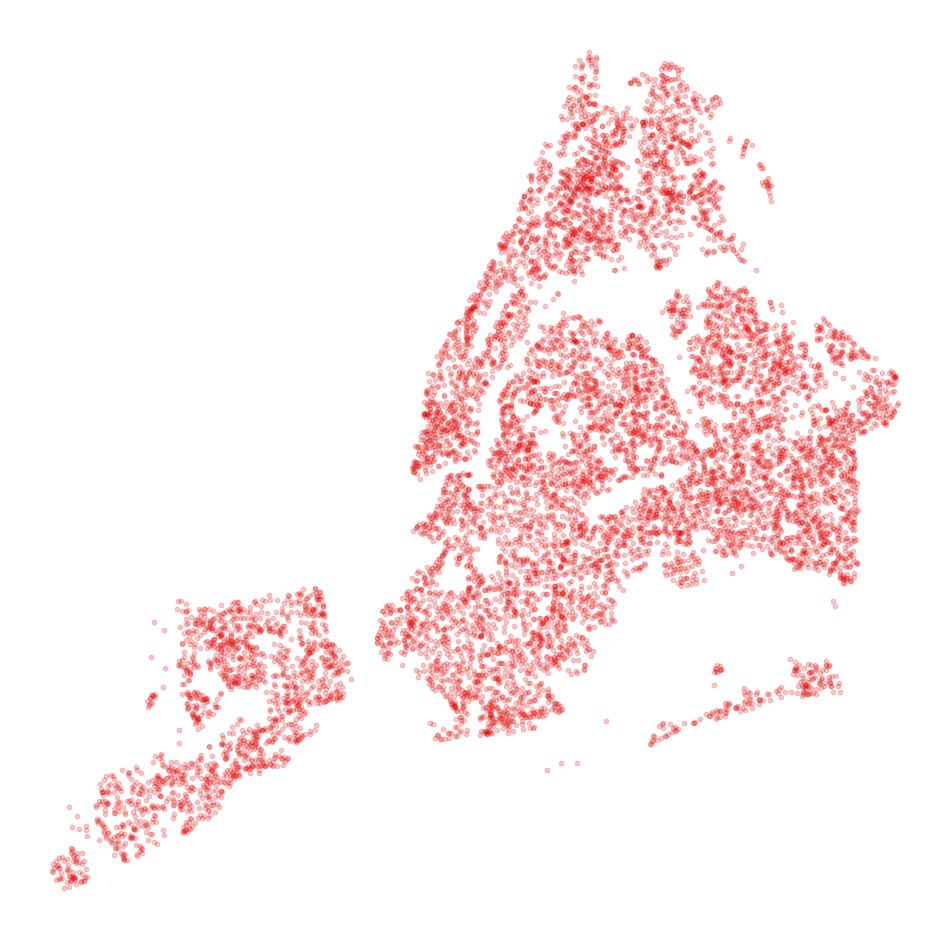

In [14]:
ax = gdf.sample(10000).plot(alpha=0.2, markersize=10,color='#E00000')

# Turn off axis
ax.axis('off')

In [40]:
# create a hexagon tessellation as a shapefile to clip raster image onto
bounding_box = gdf.dissolve().envelope[0]
bounding_box = gpd.GeoDataFrame(geometry=[bounding_box])
bounding_box.crs = gdf.crs

# import h3fy function
from tobler.util import h3fy

# creating hexagon grid using h3fy function
hex_grid = h3fy(bounding_box, resolution=8)

def rasterize(gdf, grid, column, plot=True, save_path=None):
    # Spatial join the GeoDataFrame with the grid
    merged = gpd.sjoin(gdf, grid, how='left', op='within')

    # Group by the hexagon cell and sum the column of interest
    dissolved = merged.groupby('index_right')[column].sum().reset_index()

    # Merge the dissolved data with the grid
    grid = grid.merge(dissolved, left_index=True, right_on='index_right', how='left')

    # Plot the grid
    if plot:
        fig, ax = plt.subplots(figsize=(12, 8))
        grid.plot(column=column, cmap='viridis', ax=ax, edgecolor='grey', legend=True)
        ax.axis('off')
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=gdf.crs)
        plt.show()

    # Save the result to a shapefile
    if save_path is not None:
        grid.to_file(save_path)

    return grid

/opt/homebrew/opt/ipython/libexec/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


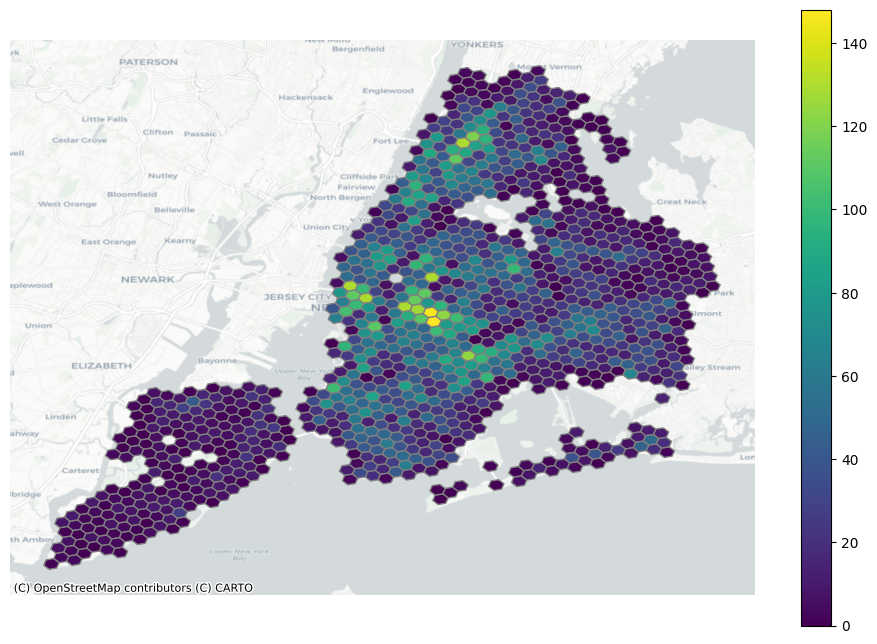

/var/folders/3_/8xdbx4ks2kj55t5nl3zg5ff00000gn/T/ipykernel_25159/3821805704.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(save_path)


In [41]:
# Save the result to a shapefile
save_path = 'rasterhex_grid.shp'
raster_grid = rasterize(gdf, hex_grid, column='n_cameras_median', save_path=save_path)


#### Raster Day/Night Data

In [51]:
rasterDay_Url = '../data/LandScan/LandScanConusDay.tif'
rasterNight_Url = '../data/LandScan/LandScanConusNight.tif'

rasterDay = rio.open(rasterDay_Url)
rasterNight = rio.open(rasterNight_Url)

In [52]:
# Raster Day and Night have same results

print('CRS:    ',rasterDay.crs) 
print('Width:  ',rasterDay.width) 
print('Height: ',rasterDay.height) 
print('Count:  ',rasterDay.count) 
print('Type:  ',type(rasterDay)) 

CRS:     EPSG:4326
Width:   69900
Height:  30300
Count:   1
Type:   <class 'rasterio.io.DatasetReader'>


In [53]:
# Metadata of raster images

rasterDay_Meta = rasterDay.meta
rasterNight_Meta = rasterNight.meta
print('Raster Day:', rasterDay_Meta)
print('Raster Night:', rasterNight_Meta)

Raster Day: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 69900, 'height': 30300, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333299999999, 0.0, -125.0,
       0.0, -0.0008333333299999999, 49.499999899)}
Raster Night: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 69900, 'height': 30300, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333299999999, 0.0, -125.0,
       0.0, -0.0008333333299999999, 49.499999899)}


In [54]:
# Min and max population density
with rio.open("../data/LandScan/LandScanConusDay.tif") as src:
    pop_density = src.read(1)
    print(np.min(pop_density), np.max(pop_density))

-32768 15852


/var/folders/3_/8xdbx4ks2kj55t5nl3zg5ff00000gn/T/ipykernel_25159/372057076.py:7: RuntimeWarning: invalid value encountered in log10
  pop_density_norm = np.log10(pop_density + 1)


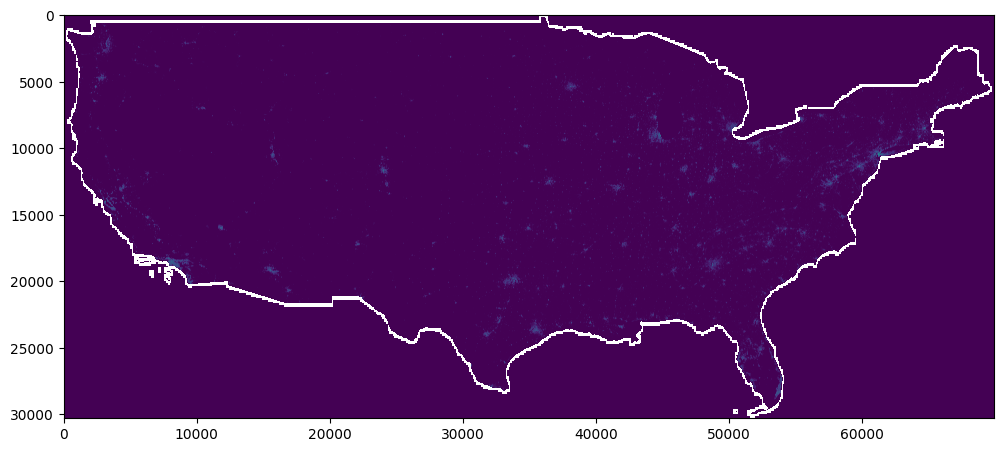

In [55]:
# The population density values are very low compared to the maximum value in the dataset, 
# making it difficult to distinguish different levels of population density. In this case, I 
# am trying to normalize the data using a logarithmic scale to enhance the visualization:

with rasterio.open('../data/LandScan/LandScanConusDay.tif') as src:
    pop_density = src.read(1)
    pop_density_norm = np.log10(pop_density + 1)
    show(pop_density_norm, cmap='viridis')

In [56]:

# Load the NYC Borough shapefile
url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
nyc = gpd.read_file(url)


# Load day and nighttime US raster
us_day_raster = rasterio.open('../data/LandScan/LandScanConusDay.tif')
us_night_raster = rasterio.open('../data/LandScan/LandScanConusNight.tif')


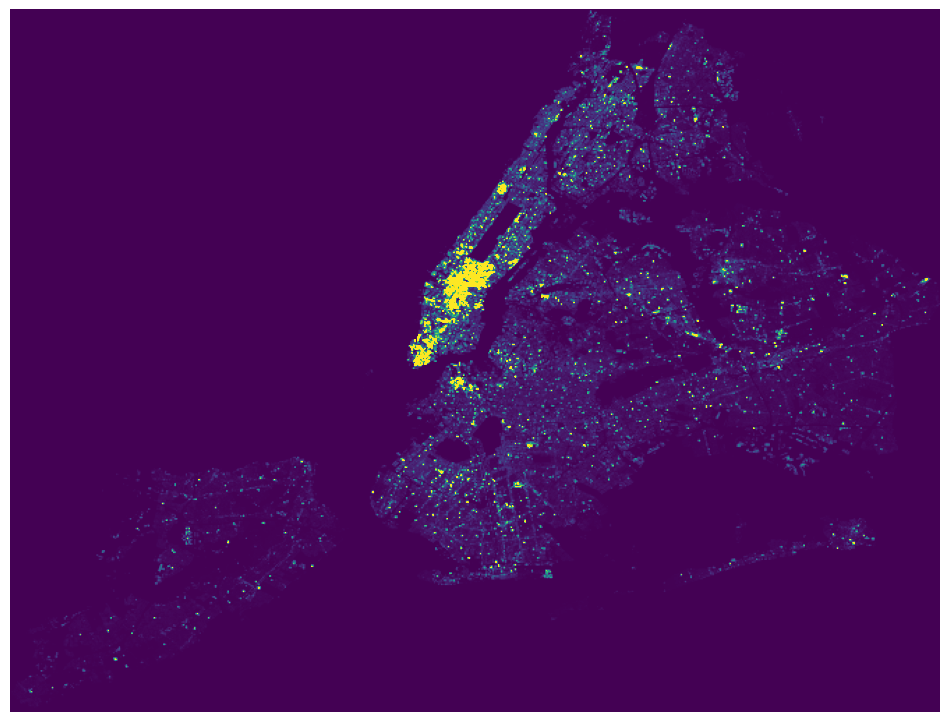

In [57]:
# Load the New York City Day Population Density


# Open the LandScan raster data
with rasterio.open('../data/LandScan/LandScanConusDay.tif')as src:
    profile = src.profile
        
    # Clip the raster data to the NYC shapefile
    out_image, out_transform = mask(src, nyc.geometry, crop=True)

    # Get the nodata value
    nodata = src.nodata
    
    # Set the nodata value and data type of the output image
    nodata = src.nodata
    out_image = np.where(out_image == nodata, np.nan, out_image)
    out_image = out_image.astype(rasterio.float32)

    profile.update({
        'dtype': rasterio.float32,
        'nodata': np.nan,
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform})
    
    #Write the output image to a new GeoTIFF file
    with rasterio.open('day_clipped_population_density.tif', 'w', **profile) as dst:
        dst.write(out_image)
    

    # Plot the clipped population density map
    plt.imshow(out_image[0], cmap='viridis', vmin=0, vmax=1000)
    plt.axis('off')
    plt.show()

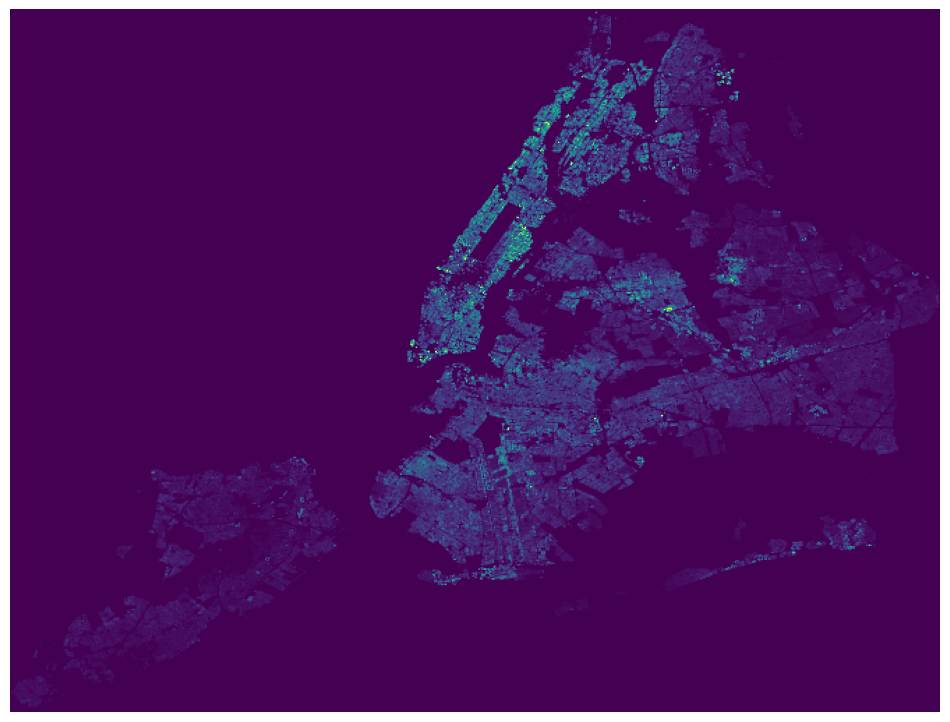

In [58]:
# Load the New York City Night Population Density

# Open the LandScan raster data
with rasterio.open('../data/LandScan/LandScanConusNight.tif')as src:
    profile = src.profile
        
    # Clip the raster data to the NYC shapefile
    out_image, out_transform = mask(src, nyc.geometry, crop=True)

    # Get the nodata value
    nodata = src.nodata
    
    # Set the nodata value and data type of the output image
    nodata = src.nodata
    out_image = np.where(out_image == nodata, np.nan, out_image)
    out_image = out_image.astype(rasterio.float32)

    profile.update({
        'dtype': rasterio.float32,
        'nodata': np.nan,
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform})
    
    #Write the output image to a new GeoTIFF file
    with rasterio.open('night_clipped_population_density.tif', 'w', **profile) as dst:
        dst.write(out_image)
    

    # Plot the clipped population density map
    plt.imshow(out_image[0], cmap='viridis', vmin=0, vmax=1000)
    plt.axis('off')
    plt.show()


Clip hexagon grid to raster population density

In [107]:
import warnings
warnings.filterwarnings("ignore")

In [108]:
hex_grid_url = '../data/RasterHex_Grid_Surveillance/rasterhex_grid.shp'
grid_url = '../data/Surveillance_Grid_4HotSpot/surveillance_grid_4hotspot.shp'

# lanscan urls
landscan_day = '../data/LandScan_Clipped_NYC/day_clipped_population_density.tif'
landscan_night = '../data/LandScan_Clipped_NYC/night_clipped_population_density.tif'

In [109]:
hex_grid = gpd.read_file(hex_grid_url)

In [110]:
hex_grid['area_sq_miles'] = hex_grid.to_crs(4326).area / 2.59e+6


In [111]:
reg_grid = gpd.read_file(grid_url)

##### Daytime Population Landscan

In [113]:
# clipping landscan daytime pop to hexagon grid
hexgrid_daytime_pops = zonal_stats(hex_grid, landscan_day, stats='sum')

# clipping landscan daytime pop to regular grid 
reg_grid_daytime_pops = zonal_stats(reg_grid, landscan_day, stats='sum')

In [114]:
hexgrid_daytime_pops[:5]

[{'sum': 30956.0},
 {'sum': 0.0},
 {'sum': 8742.0},
 {'sum': 0.0},
 {'sum': 1685.0}]

In [76]:
hex_grid['daytime_population'] = [i['sum'] for i in hexgrid_daytime_pops]


In [115]:
reg_grid['daytime_population'] = [i['sum'] for i in reg_grid_daytime_pops]

In [77]:
hex_grid['daytime_population_per_sq_mile'] = hex_grid['daytime_population'] / hex_grid['area_sq_miles']


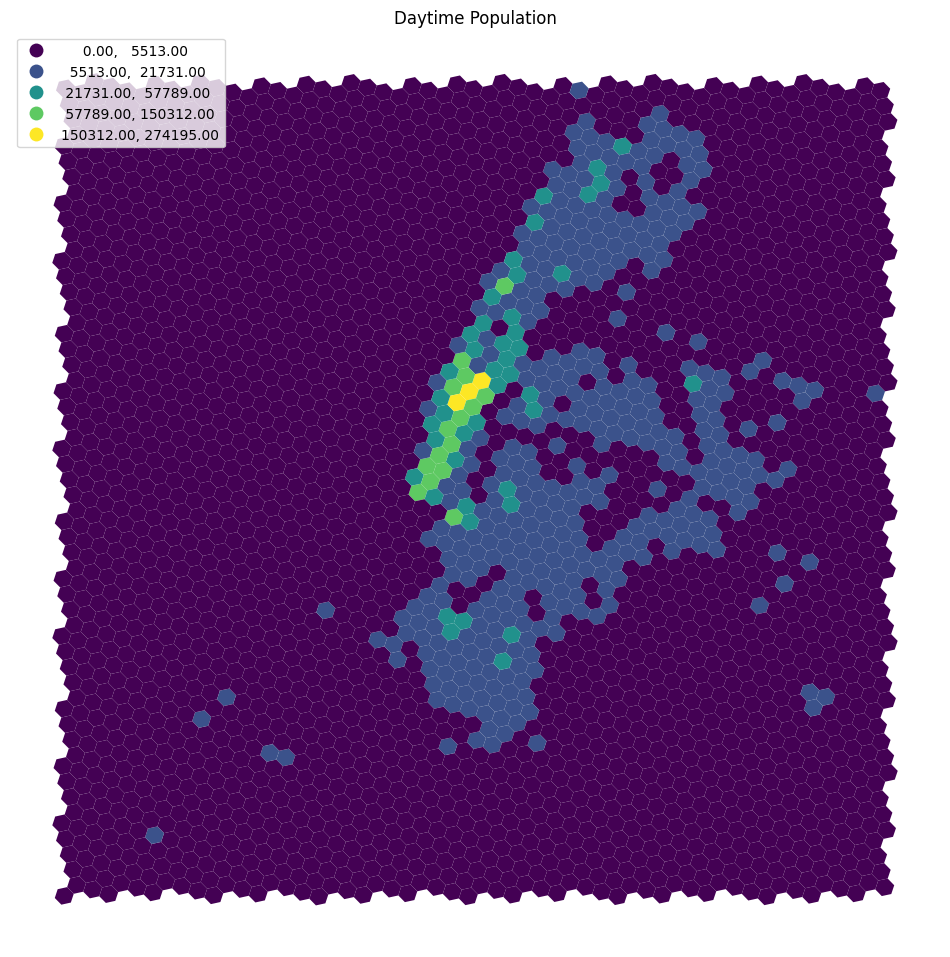

In [80]:
ax = hex_grid.plot(column='daytime_population', scheme='natural_breaks', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Daytime Population');

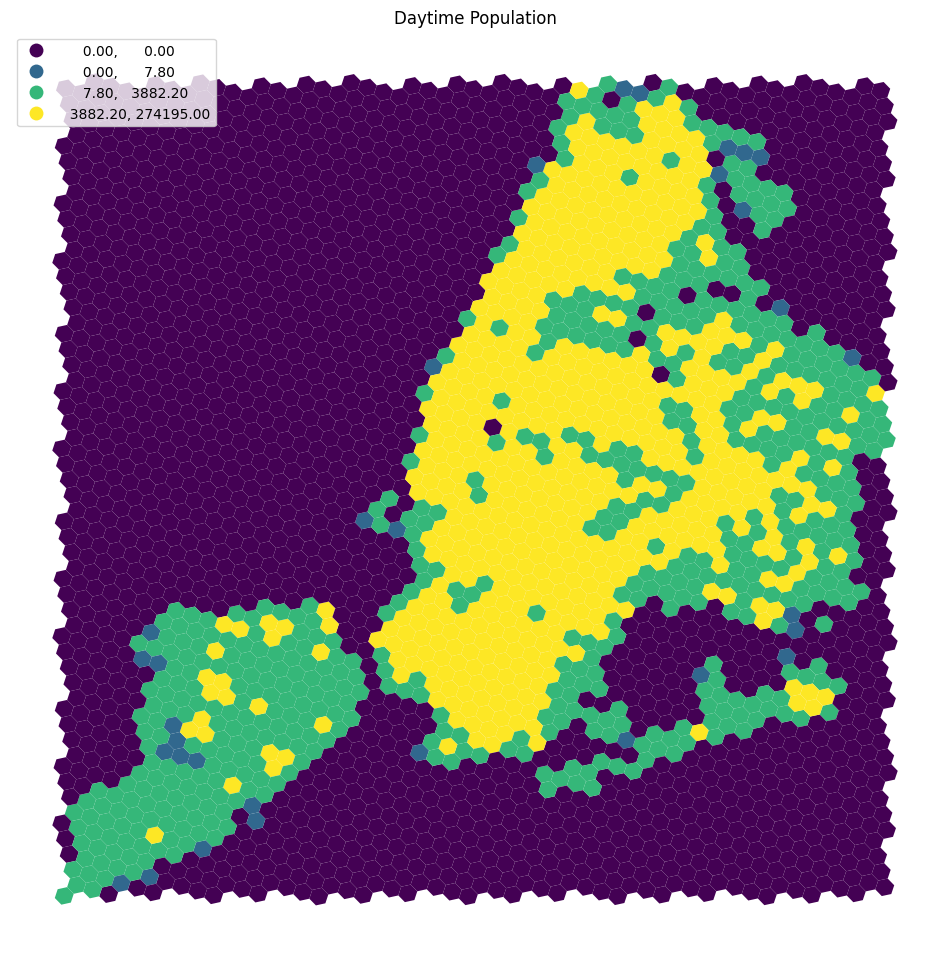

In [81]:
ax = hex_grid.plot(column='daytime_population', scheme='quantiles', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Daytime Population');

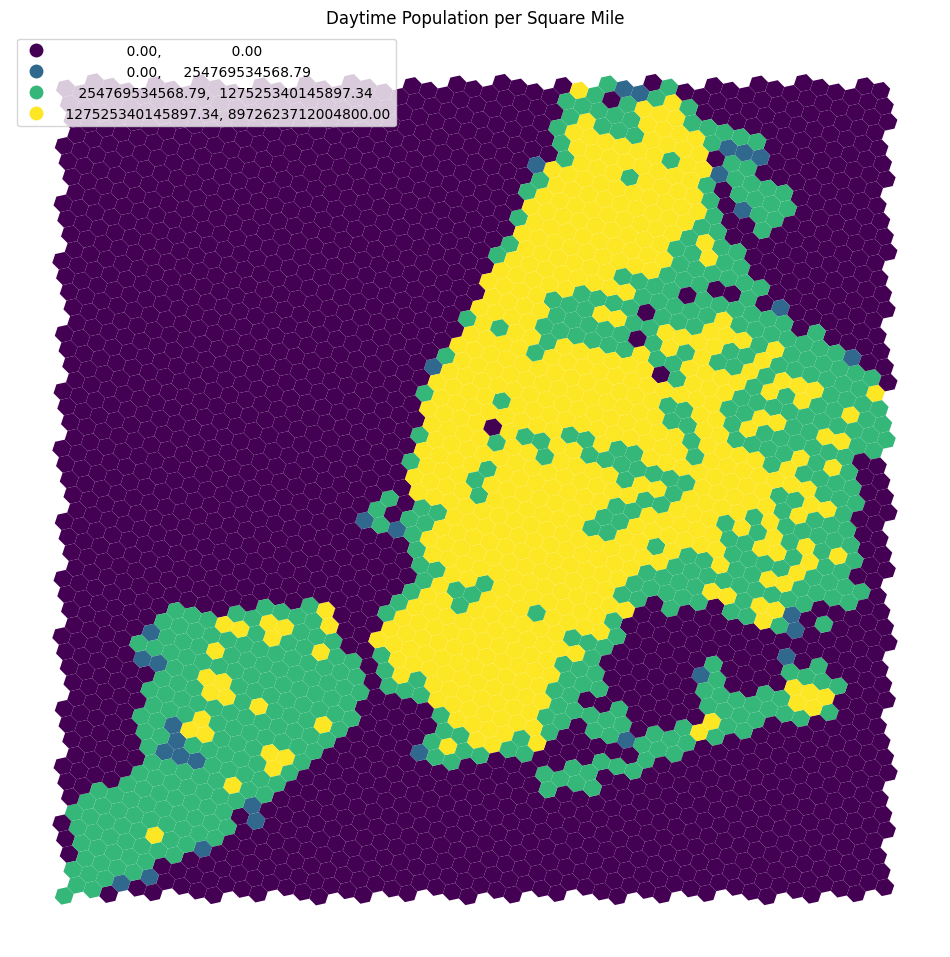

In [82]:
ax = hex_grid.plot(column='daytime_population_per_sq_mile', scheme='quantiles', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Daytime Population per Square Mile');


##### Nighttime Population Landscan

In [116]:
hexgrid_nighttime_pops = zonal_stats(hex_grid, landscan_night, stats='sum')

# night time population for regular grid
reg_grid_nighttime_pops = zonal_stats(reg_grid, landscan_night, stats='sum')


In [117]:
hex_grid['nighttime_population'] = [i['sum'] for i in hexgrid_nighttime_pops]

# night time population for regular grid
reg_grid['nighttime_population'] = [i['sum'] for i in reg_grid_nighttime_pops]


In [85]:
hex_grid['nighttime_population_per_sq_mile'] = hex_grid['nighttime_population'] / hex_grid['area_sq_miles']


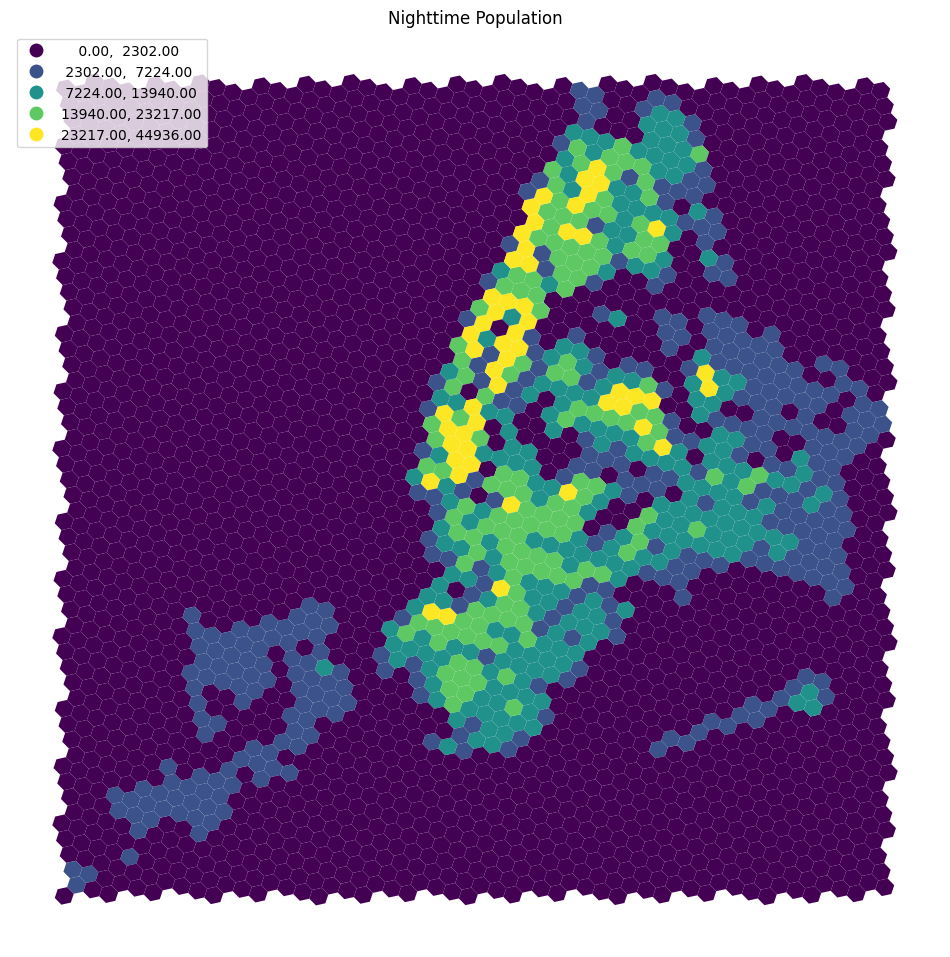

In [87]:
ax = hex_grid.plot(column='nighttime_population', scheme='natural_breaks', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Nighttime Population');

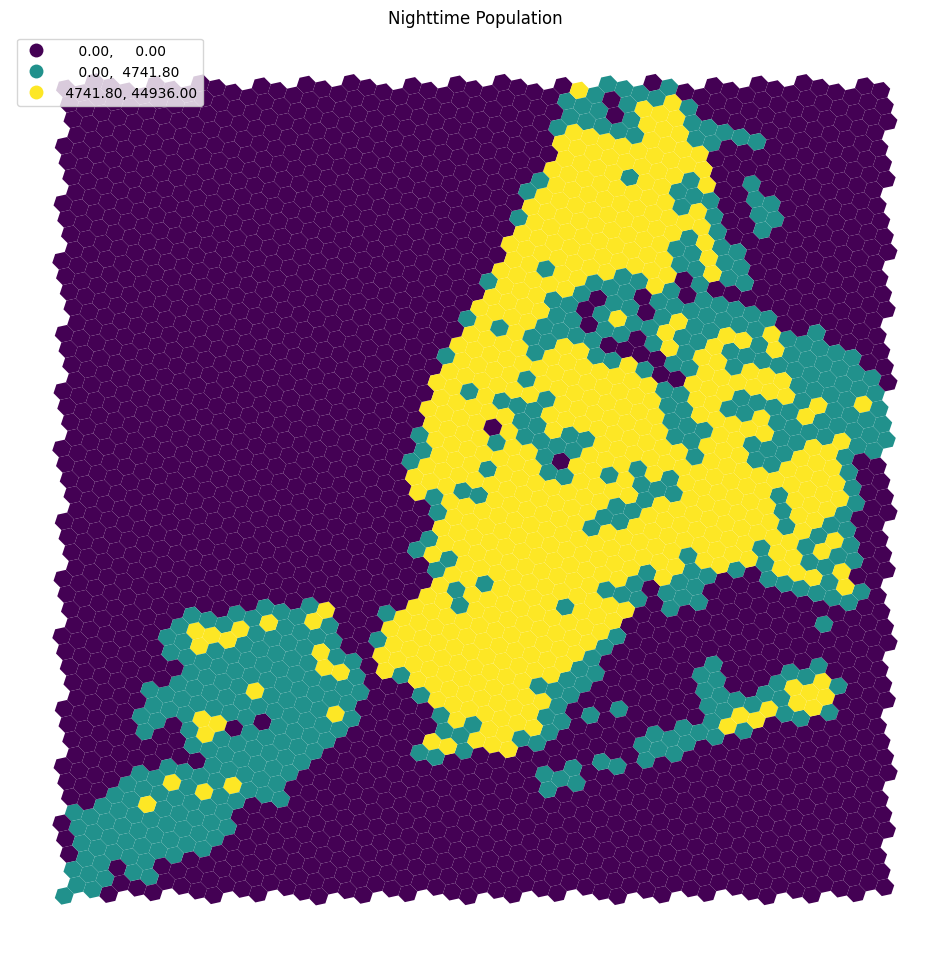

In [88]:
ax = hex_grid.plot(column='nighttime_population', scheme='quantiles', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Nighttime Population');

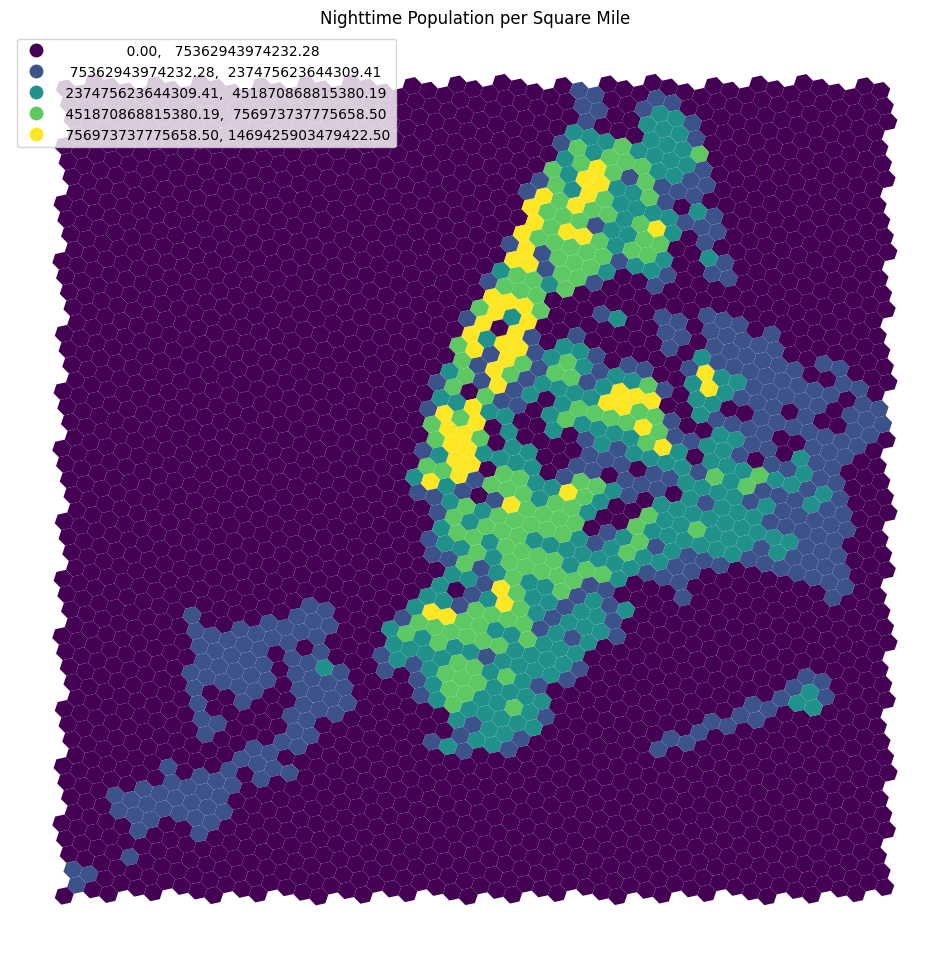

In [90]:
ax = hex_grid.plot(column='nighttime_population_per_sq_mile', scheme='natural_breaks', legend=True, legend_kwds={'loc': 'upper left'})
ax.axis('off')
ax.set_title('Nighttime Population per Square Mile');

In [93]:
hex_grid.head(2)

index       index_righ  n_cameras_   
0  200.0  882a100883fffff        32.0  \
1    NaN  882a10632bfffff         NaN   

                                            geometry  area_sq_miles   
0  POLYGON ((-73.97033 40.79441, -73.96592 40.791...   3.059452e-11  \
1  POLYGON ((-74.22508 40.64455, -74.22065 40.641...   3.044858e-11   

   daytime_population  daytime_population_per_sq_mile  nighttime_population   
0             30956.0                    1.011815e+15               40367.0  \
1                 0.0                    0.000000e+00                   0.0   

   nighttime_population_per_sq_mile  
0                      1.319419e+15  
1                      0.000000e+00

In [95]:
# saving hex grid with daytime and nightttime population
# hex_grid.to_file("hexgrid_population.shp")

In [119]:
# saving hex grid with daytime and nightttime population
# reg_grid.to_file("reg_grid_population.shp")